🚀 เริ่มระบบวิเคราะห์หุ้น: BTC
✅ ดึงข้อมูลได้ 729 แถว
🔍 พบ Head & Shoulders Pattern: 3 รูปแบบ
📊 LSTM Dataset - Train: (559, 30, 3)


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


📈 LSTM Performance: MAE 0.01 บาท
🔮 ราคาพยากรณ์ 50 วันข้างหน้า:
   วันที่ 1: 0.26 บาท
   วันที่ 2: 0.26 บาท
   วันที่ 3: 0.26 บาท
   วันที่ 4: 0.26 บาท
   วันที่ 5: 0.26 บาท
   วันที่ 6: 0.26 บาท
   วันที่ 7: 0.26 บาท
   วันที่ 8: 0.26 บาท
   วันที่ 9: 0.26 บาท
   วันที่ 10: 0.26 บาท
   วันที่ 11: 0.26 บาท
   วันที่ 12: 0.26 บาท
   วันที่ 13: 0.26 บาท
   วันที่ 14: 0.26 บาท
   วันที่ 15: 0.26 บาท
   วันที่ 16: 0.26 บาท
   วันที่ 17: 0.26 บาท
   วันที่ 18: 0.26 บาท
   วันที่ 19: 0.26 บาท
   วันที่ 20: 0.26 บาท
   วันที่ 21: 0.26 บาท
   วันที่ 22: 0.26 บาท
   วันที่ 23: 0.26 บาท
   วันที่ 24: 0.26 บาท
   วันที่ 25: 0.26 บาท
   วันที่ 26: 0.26 บาท
   วันที่ 27: 0.26 บาท
   วันที่ 28: 0.26 บาท
   วันที่ 29: 0.26 บาท
   วันที่ 30: 0.26 บาท
   วันที่ 31: 0.26 บาท
   วันที่ 32: 0.26 บาท
   วันที่ 33: 0.26 บาท
   วันที่ 34: 0.26 บาท
   วันที่ 35: 0.26 บาท
   วันที่ 36: 0.26 บาท
   วันที่ 37: 0.26 บาท
   วันที่ 38: 0.26 บาท
   วันที่ 39: 0.26 บาท
   วันที่ 40: 0.26 บาท
   วันที่ 41: 0.26 บาท
   

/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📰 กำลังวิเคราะห์ Sentiment สำหรับ BTC...


Device set to use mps:0


✅ Sentiment Score เฉลี่ย: -0.47 (Negative 🔴)


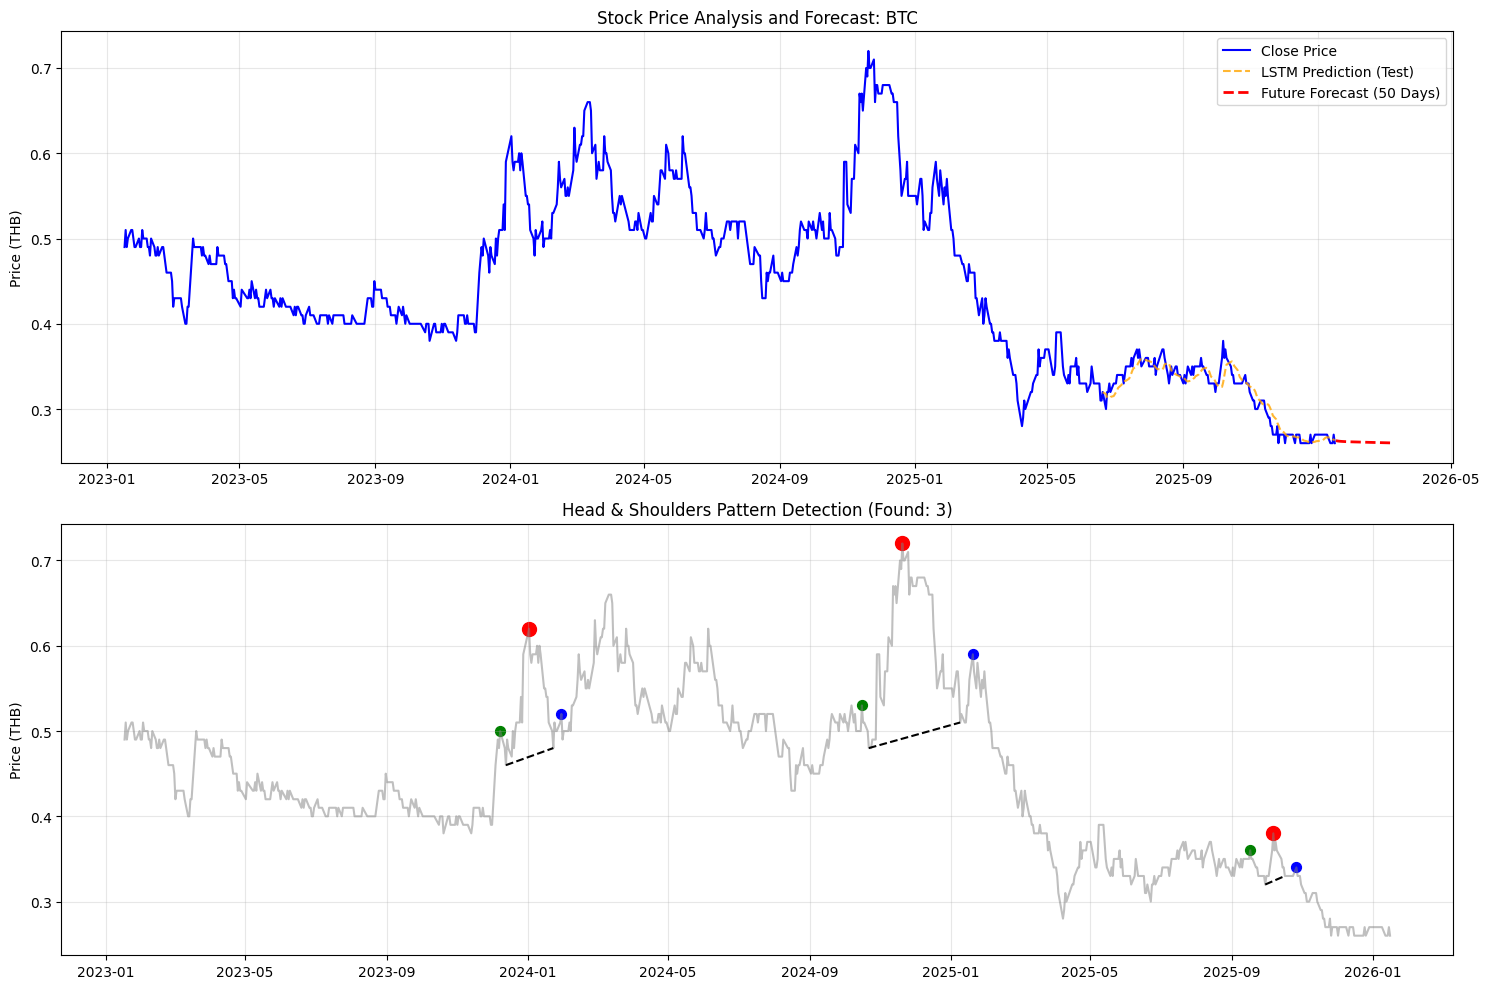


📊 สรุปผลการวิเคราะห์ BTC
   - พยากรณ์พรุ่งนี้: 0.26 บาท
   - Sentiment: -0.47 (Negative 🔴)
   - Technical: ระวังรูปแบบ H&S


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from cassandra.cluster import Cluster
from transformers import pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, mean_absolute_error

# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# ========================================
# 1. ตั้งค่าพารามิเตอร์และการดึงข้อมูล
# ========================================
SYMBOL = 'BTC'  
CASSANDRA_HOST, CASSANDRA_PORT = '127.0.0.1', 9042
SEQ_LEN = 30
FORECAST_DAYS = 50 

def get_data(symbol):
    cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
    session = cluster.connect('data_stock')
    query = "SELECT time, open, high, low, close, volume FROM candlestick_data WHERE symbol=%s LIMIT 1000 ALLOW FILTERING"
    df = pd.DataFrame(list(session.execute(query, (symbol,))))
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    cluster.shutdown()
    return df

print(f"🚀 เริ่มระบบวิเคราะห์หุ้น: {SYMBOL}")
df = get_data(SYMBOL)
print(f"✅ ดึงข้อมูลได้ {len(df)} แถว")

# ========================================
# 2. ตรวจจับรูปแบบ Head & Shoulders
# ========================================
def get_hs_labels(df, window=5):
    prices = df['close'].values
    labels = np.zeros(len(prices))
    peaks = [i for i in range(window, len(prices)-window) if all(prices[i] > prices[i-j] and prices[i] > prices[i+j] for j in range(1, window+1))]
    patterns = []
    for i in range(len(peaks)-2):
        ls, h, rs = peaks[i], peaks[i+1], peaks[i+2]
        if prices[h] > prices[ls]*1.03 and prices[h] > prices[rs]*1.03 and abs(prices[ls]-prices[rs])/prices[ls] < 0.12:
            labels[ls-5:rs+6] = 1
            lv = ls + np.argmin(prices[ls:h+1])
            rv = h + np.argmin(prices[h:rs+1])
            patterns.append({'ls': (ls, prices[ls]), 'h': (h, prices[h]), 'rs': (rs, prices[rs]), 'neck': [(lv, prices[lv]), (rv, prices[rv])]})
    return labels, patterns

labels, patterns_found = get_hs_labels(df)
print(f"🔍 พบ Head & Shoulders Pattern: {len(patterns_found)} รูปแบบ")

# ========================================
# 3. เทรน LSTM (Price Prediction)
# ========================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['high', 'low', 'close']])
X_l, y_l = [], []
for i in range(len(scaled_data)-SEQ_LEN):
    X_l.append(scaled_data[i:i+SEQ_LEN])
    y_l.append(scaled_data[i+SEQ_LEN, 2])

X_l, y_l = np.array(X_l), np.array(y_l)
split = int(len(X_l) * 0.8)
print(f"📊 LSTM Dataset - Train: {X_l[:split].shape}")

model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 3)),
    LSTM(32),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_l[:split], y_l[:split], epochs=20, batch_size=32, verbose=0, callbacks=[EarlyStopping(patience=3)])

def inv(v): return scaler.inverse_transform(np.column_stack([np.zeros((len(v), 2)), v]))[:, 2]

# ทำนายช่วง Test (เส้นสีส้ม)
y_pred_test = inv(model_lstm.predict(X_l[split:], verbose=0))
test_times = df['time'].iloc[split + SEQ_LEN : split + SEQ_LEN + len(y_pred_test)]
print(f"📈 LSTM Performance: MAE {mean_absolute_error(inv(y_l[split:]), y_pred_test):.2f} บาท")

# พยากรณ์อนาคต 5 วัน
curr = scaled_data[-SEQ_LEN:].reshape(1, SEQ_LEN, 3)
future_preds = []
for _ in range(FORECAST_DAYS):
    p = model_lstm.predict(curr, verbose=0)[0,0]
    future_preds.append(p)
    curr = np.append(curr[:, 1:, :], [[[p,p,p]]], axis=1)

rescaled_future = inv(np.array(future_preds))
print(f"🔮 ราคาพยากรณ์ {FORECAST_DAYS} วันข้างหน้า:")
for i, p in enumerate(rescaled_future, 1): print(f"   วันที่ {i}: {p:.2f} บาท")

# ========================================
# 4. CNN & Sentiment Analysis (รันจริง)
# ========================================
X_c, y_c = [], []
scaled_cnn = MinMaxScaler().fit_transform(df[['close', 'volume']])
for i in range(len(scaled_cnn)-SEQ_LEN):
    X_c.append(scaled_cnn[i:i+SEQ_LEN]); y_c.append(labels[i+SEQ_LEN])
X_c, y_c = np.array(X_c), np.array(y_c)

# ป้องกัน Error หากไม่พบ Pattern ในข้อมูล Train
unique_classes = np.unique(y_c[:split])
if len(unique_classes) > 1:
    cw = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_c[:split])))
else:
    cw = {0: 1.0, 1: 1.0}

model_cnn = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(SEQ_LEN, 2)),
    MaxPooling1D(2), Flatten(), Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_c[:split], y_c[:split], epochs=15, verbose=0, class_weight=cw)

# --- Sentiment Analysis Section ---
print(f"📰 กำลังวิเคราะห์ Sentiment สำหรับ {SYMBOL}...")
try:
    sentiment_task = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
    news_samples = [
        f"{SYMBOL} reports record breaking Q4 profits with 15% growth",
        f"Consumer spending at {SYMBOL} stores declines amid inflation",
        f"New digital wallet policy expected to boost {SYMBOL} retail sales",
        f"Analysts downgrade {SYMBOL} rating due to high debt levels"
    ]
    results = sentiment_task(news_samples)
    scores = [res['score'] if res['label'] == 'POSITIVE' else -res['score'] for res in results]
    avg_sentiment = np.mean(scores)
    sent_res = f"{avg_sentiment:.2f} ({'Positive 🟢' if avg_sentiment > 0 else 'Negative 🔴'})"
    print(f"✅ Sentiment Score เฉลี่ย: {sent_res}")
except Exception as e:
    print(f"⚠️ Sentiment Error: {e}")
    avg_sentiment = 0

# ========================================
# 5. Visualization (Dashboard)
# ========================================


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Price & Forecast
ax1.plot(df['time'], df['close'], label='Close Price', color='blue', lw=1.5)
ax1.plot(test_times, y_pred_test, label='LSTM Prediction (Test)', linestyle='--', color='orange', alpha=0.8)
f_dates = pd.date_range(df['time'].iloc[-1] + timedelta(1), periods=FORECAST_DAYS)
ax1.plot(f_dates, rescaled_future, label=f'Future Forecast ({FORECAST_DAYS} Days)', linestyle='--', color='red', lw=2)

ax1.set_title(f'Stock Price Analysis and Forecast: {SYMBOL}')
ax1.set_ylabel('Price (THB)')
ax1.legend(); ax1.grid(True, alpha=0.3)

# Plot 2: Patterns
ax2.plot(df['time'], df['close'], color='gray', alpha=0.5, label='Close Price')
for p in patterns_found:
    ax2.scatter(df['time'].iloc[p['ls'][0]], p['ls'][1], color='green', marker='o', s=50)
    ax2.scatter(df['time'].iloc[p['h'][0]], p['h'][1], color='red', marker='o', s=100)
    ax2.scatter(df['time'].iloc[p['rs'][0]], p['rs'][1], color='blue', marker='o', s=50)
    ax2.plot([df['time'].iloc[p['neck'][0][0]], df['time'].iloc[p['neck'][1][0]]], 
             [p['neck'][0][1], p['neck'][1][1]], 'k--', lw=1.5)

ax2.set_title(f'Head & Shoulders Pattern Detection (Found: {len(patterns_found)})')
ax2.set_ylabel('Price (THB)'); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 6. สรุปผล
# ========================================
print("\n" + "="*50)
print(f"📊 สรุปผลการวิเคราะห์ {SYMBOL}")
print(f"   - พยากรณ์พรุ่งนี้: {rescaled_future[0]:.2f} บาท")
print(f"   - Sentiment: {sent_res}")
print(f"   - Technical: {'ระวังรูปแบบ H&S' if len(patterns_found) > 0 else 'ไม่พบสัญญาณเตือน'}")
print("="*50)